In [2]:
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=7f30895af14fa82db6e8b5b78d42d96e0fa3cabf7a77f9c178cb2db434908368
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


Credit Card Fraud Detection System

       Feature Information        
╭────────────────────────┬───────╮
│ Feature Name           │ Type  │
├────────────────────────┼───────┤
│ over_draft             │ int64 │
│ credit_usage           │ int64 │
│ credit_history         │ int64 │
│ purpose                │ int64 │
│ current_balance        │ int64 │
│ Average_Credit_Balance │ int64 │
│ employment             │ int64 │
│ location               │ int64 │
│ personal_status        │ int64 │
│ other_parties          │ int64 │
│ residence_since        │ int64 │
│ property_magnitude     │ int64 │
│ cc_age                 │ int64 │
│ other_payment_plans    │ int64 │
│ housing                │ int64 │
│ existing_credits       │ int64 │
│ job                    │ int64 │
│ num_dependents         │ int64 │
│ own_telephone          │ int64 │
│ foreign_worker         │ int64 │
╰────────────────────────┴───────╯

         Class Distribution         
╭──────────────┬─────────┬─────────╮
│ Stage        │ Class 0 │ Class 1 │
├──────────────┼─────────┼─────────┤
│ Before SMOTE │ 300     │ 700     │
│ After SMOTE  │ 700     │ 700     │
╰──────────────┴─────────┴─────────╯

Output()

           Classification Report           
╭─────────┬───────────┬────────┬──────────╮
│ Metric  │ Precision │ Recall │ F1-Score │
├─────────┼───────────┼────────┼──────────┤
│ Class 0 │ 0.797     │ 0.901  │ 0.846    │
│ Class 1 │ 0.902     │ 0.799  │ 0.847    │
╰─────────┴───────────┴────────┴──────────╯

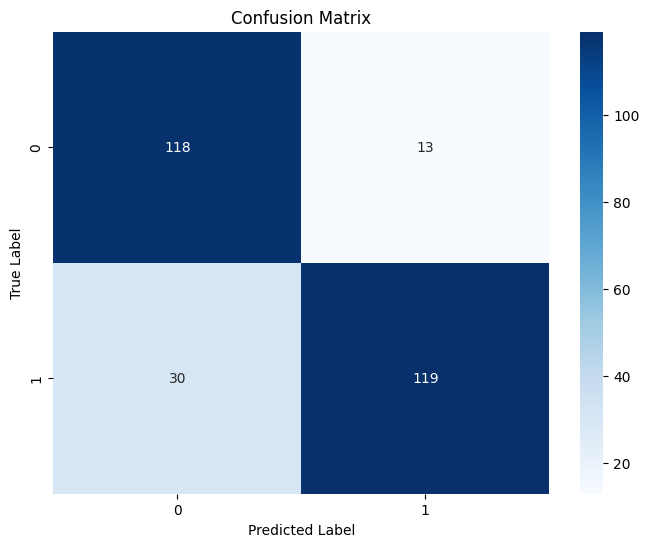

Output()

 Cross-Validation  
      Results      
╭─────────┬───────╮
│ Fold    │ Score │
├─────────┼───────┤
│ Fold 1  │ 0.732 │
│ Fold 2  │ 0.729 │
│ Fold 3  │ 0.900 │
│ Fold 4  │ 0.850 │
│ Fold 5  │ 0.893 │
│ Average │ 0.821 │
╰─────────┴───────╯

In [4]:
"""
Name: Antoine Gaton
Date: October 20, 2024
Course: CS379
Description: This Python script implements a credit card fraud detection system
using a Random Forest classifier, balanced with SMOTE to handle class imbalance.
It preprocesses and encodes the data, trains the model with cross-validation,
and provides detailed performance metrics, including a classification report,
confusion matrix, and visualizations.
GitHub Repo: https://github.com/ayorgo/credit-card-fraud-detection
"""

# Import necessary libraries
import requests
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.progress import track
from rich.layout import Layout
from rich import box
import arff
import warnings
warnings.filterwarnings('ignore')

# Initialize Rich console
console = Console()

def load_arff_data(file_path):
    """
    Load and prepare the ARFF dataset
    Args:
        file_path: Path to the ARFF file
    Returns:
        Preprocessed DataFrame
    """
    with console.status("[bold green]Loading ARFF dataset...") as status:
        # Load ARFF file
        data = arff.load(open(file_path))
        df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

        # Display dataset information
        console.print(Panel(f"Dataset Shape: {df.shape}",
                          title="Data Loading Complete",
                          style="green"))
        return df

def preprocess_data(df):
    """
    Preprocess the data including handling categorical variables
    Args:
        df: Input DataFrame
    Returns:
        Preprocessed features and labels
    """
    with console.status("[bold yellow]Preprocessing data...") as status:
        # Encode categorical variables
        le = LabelEncoder()
        categorical_columns = df.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            df[col] = le.fit_transform(df[col].astype(str))

        # Separate features and target
        X = df.drop('class', axis=1)
        y = df['class']

        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Create feature names table
        feature_table = Table(title="Feature Information", box=box.ROUNDED)
        feature_table.add_column("Feature Name", style="cyan")
        feature_table.add_column("Type", style="magenta")

        for col in X.columns:
            feature_table.add_row(col, str(X[col].dtype))

        console.print(feature_table)

        return X_scaled, y

def handle_imbalance(X, y):
    """
    Handle class imbalance using SMOTE
    Args:
        X: Feature matrix
        y: Target vector
    Returns:
        Balanced feature matrix and target vector
    """
    with console.status("[bold blue]Applying SMOTE...") as status:
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)

        # Display class distribution
        class_dist = Table(title="Class Distribution", box=box.ROUNDED)
        class_dist.add_column("Stage", style="cyan")
        class_dist.add_column("Class 0", style="green")
        class_dist.add_column("Class 1", style="red")

        class_dist.add_row(
            "Before SMOTE",
            str(sum(y == 0)),
            str(sum(y == 1))
        )
        class_dist.add_row(
            "After SMOTE",
            str(sum(y_balanced == 0)),
            str(sum(y_balanced == 1))
        )

        console.print(class_dist)

        return X_balanced, y_balanced

def train_model(X, y):
    """
    Train the Random Forest model with progress tracking
    Args:
        X: Feature matrix
        y: Target vector
    Returns:
        Trained model and performance metrics
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train model
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    # Train with progress tracking
    with console.status("[bold green]Training Random Forest model...") as status:
        rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    return rf_model, X_test, y_test, y_pred

def evaluate_model(model, X_test, y_test, y_pred):
    """
    Evaluate model performance with rich visualizations
    Args:
        model: Trained model
        X_test: Test features
        y_test: True labels
        y_pred: Predicted labels
    """
    # Create classification report table
    report = classification_report(y_test, y_pred, output_dict=True)
    report_table = Table(title="Classification Report", box=box.ROUNDED)
    report_table.add_column("Metric", style="cyan")
    report_table.add_column("Precision", style="magenta")
    report_table.add_column("Recall", style="green")
    report_table.add_column("F1-Score", style="yellow")

    for label in ['0', '1']:
        report_table.add_row(
            f"Class {label}",
            f"{report[label]['precision']:.3f}",
            f"{report[label]['recall']:.3f}",
            f"{report[label]['f1-score']:.3f}"
        )

    console.print(report_table)

    # Confusion matrix visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main():
    """
    Main function to orchestrate the fraud detection process
    """
    console.print("[bold magenta]Credit Card Fraud Detection System[/bold magenta]")

    # Load data from the CSV URL
    url = 'https://raw.githubusercontent.com/ayorgo/german-credit/refs/heads/master/data/german-credit.csv'
    response = requests.get(url)

    # Convert the content to a DataFrame
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)

    # Preprocess data
    X_scaled, y = preprocess_data(df)

    # Handle class imbalance
    X_balanced, y_balanced = handle_imbalance(X_scaled, y)

    # Train and evaluate model
    model, X_test, y_test, y_pred = train_model(X_balanced, y_balanced)

    # Evaluate results
    evaluate_model(model, X_test, y_test, y_pred)

    # Cross-validation
    with console.status("[bold yellow]Performing cross-validation...") as status:
        cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=5)
        cv_table = Table(title="Cross-Validation Results", box=box.ROUNDED)
        cv_table.add_column("Fold", style="cyan")
        cv_table.add_column("Score", style="green")

        for i, score in enumerate(cv_scores, 1):
            cv_table.add_row(f"Fold {i}", f"{score:.3f}")

        cv_table.add_row("Average", f"{cv_scores.mean():.3f}")
        console.print(cv_table)

if __name__ == "__main__":
    main()